Working directory: /Users/daphnerosemolina/Desktop/nhanes_diet_labs-main 2
Loaded 7,342 rows

Columns: ['SEQN', 'age', 'sex', 'raceeth', 'pir', 'WTMEC2YR', 'SDMVSTRA', 'SDMVPSU', 'energy_kcal', 'carbs_g', 'protein_g', 'fat_g', 'fiber_g', 'added_sugar_g', 'sodium_mg', 'WTDRD1', 'bmi', 'hba1c', 'hscrp', 'hdl', 'trig', 'cycle', 'carb_pct', 'protein_pct', 'fat_pct', 'fiber_density', 'sugar_pct', 'sodium_density', 'sex_female', 'wt_diet_day1', 'energy_outlier', 'lab_outlier', 'kept_in_model']
                        mean           std           min            max
SEQN            98333.833424   2671.810175  93704.000000  102956.000000
age                35.909561     24.905504      0.000000      80.000000
pir                 2.401393      1.596056      0.000000       5.000000
WTMEC2YR        38767.856266  45731.306689   3052.657625  419762.836488
SDMVSTRA          141.047535      4.155774    134.000000     148.000000
SDMVPSU             1.516344      0.499767      1.000000       2.000000
ene

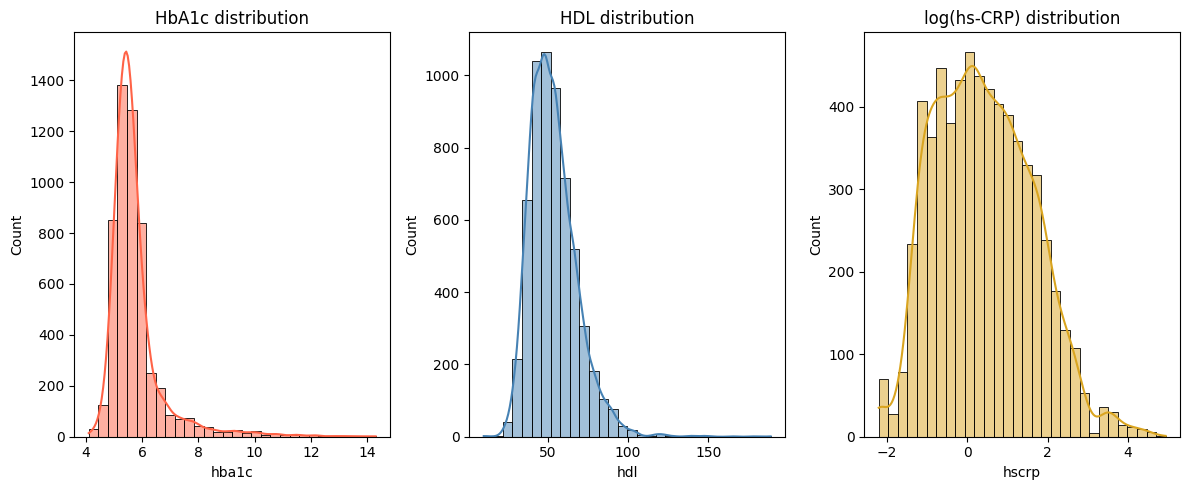

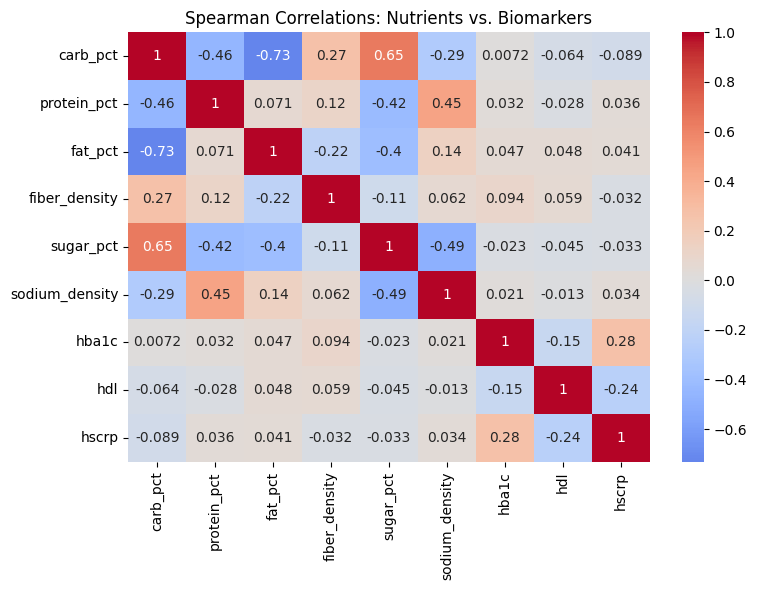

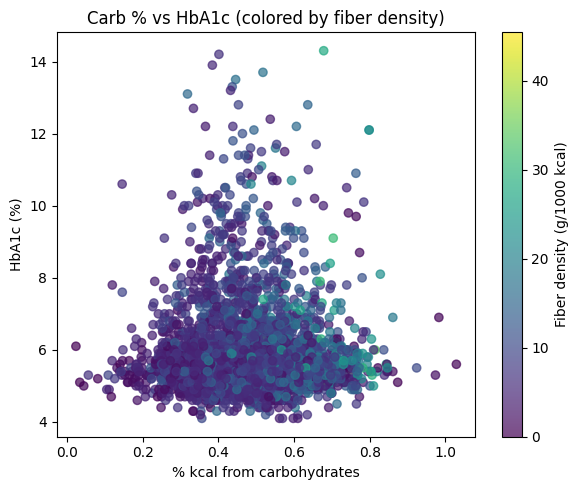

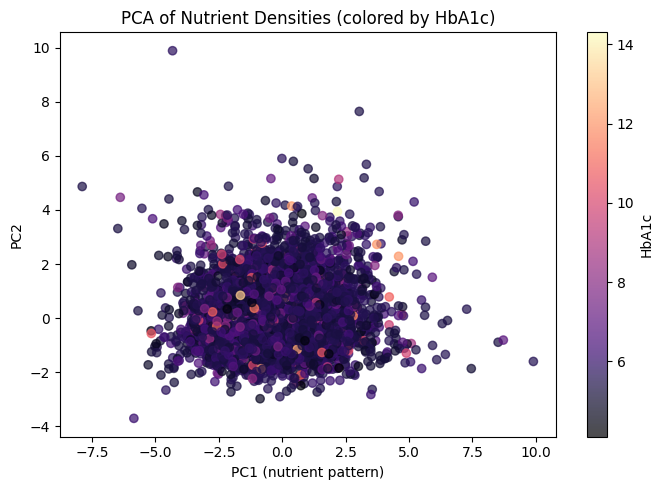

In [2]:
# 01_ingest_clean.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import numpy as np
import os
os.chdir("..")  # move one directory up so config.yaml is found
print("Working directory:", os.getcwd())

# Load configuration
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

analytic_path = Path(config["paths"]["tidy"]) / "diet_labs_analytic.csv"
df = pd.read_csv(analytic_path)
print(f"Loaded {len(df):,} rows")

# ----------------------------
# Basic overview
# ----------------------------
print("\nColumns:", list(df.columns))
print(df.describe().T[["mean", "std", "min", "max"]])

# ----------------------------
# Plot: Histograms of key labs
# ----------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.histplot(df["hba1c"], bins=30, color="tomato", kde=True)
plt.title("HbA1c distribution")

plt.subplot(1, 3, 2)
sns.histplot(df["hdl"], bins=30, color="steelblue", kde=True)
plt.title("HDL distribution")

plt.subplot(1, 3, 3)
sns.histplot(np.log(df["hscrp"]), bins=30, color="goldenrod", kde=True)
plt.title("log(hs-CRP) distribution")
plt.tight_layout()
plt.savefig("figures/hists_labs.png", dpi=config["viz"]["dpi"])
plt.show()

# ----------------------------
# Correlation heatmap
# ----------------------------
nutrients = ["carb_pct", "protein_pct", "fat_pct", "fiber_density",
             "sugar_pct", "sodium_density"]
labs = ["hba1c", "hdl", "hscrp"]

corr = df[nutrients + labs].corr(method="spearman")
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman Correlations: Nutrients vs. Biomarkers")
plt.tight_layout()
plt.savefig("figures/corr_heatmap.png", dpi=config["viz"]["dpi"])
plt.show()

# ----------------------------
# Scatter: carbs vs HbA1c (color by fiber)
# ----------------------------
plt.figure(figsize=(6, 5))
sc = plt.scatter(df["carb_pct"], df["hba1c"], c=df["fiber_density"],
                 cmap="viridis", alpha=0.7)
plt.colorbar(sc, label="Fiber density (g/1000 kcal)")
plt.xlabel("% kcal from carbohydrates")
plt.ylabel("HbA1c (%)")
plt.title("Carb % vs HbA1c (colored by fiber density)")
plt.tight_layout()
plt.savefig("figures/scatter_carb_hba1c.png", dpi=config["viz"]["dpi"])
plt.show()

# ----------------------------
# PCA nutrient pattern (optional)
# ----------------------------
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df[nutrients].dropna()
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_std)

plt.figure(figsize=(7, 5))
sc = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                 c=df.loc[X.index, "hba1c"], cmap="magma", alpha=0.7)
plt.colorbar(sc, label="HbA1c")
plt.xlabel("PC1 (nutrient pattern)")
plt.ylabel("PC2")
plt.title("PCA of Nutrient Densities (colored by HbA1c)")
plt.tight_layout()
plt.savefig("figures/pca_biplot.png", dpi=config["viz"]["dpi"])
plt.show()
